# Objective
 In this spark notebook I will build crop recommendation models to suggest and recommend crops for Jordanian farmers based on some surroundings factors:  

# The features (Surrounding factors)

1. **Nitrogen** - the ratio of Nitrogen content in the soil
2. **Phosphorus** - the ratio of Phosphorus content in the soil
3. **Potassium** - the ratio of Potassium content in the soil
4. **Temperature** - temperature in degrees Celsius
5. **Humidity** - relative humidity in %
6. **pH_Value** - pH value of the soil
7. **Rainfall**- rainfall in mm
8. **Crop** - What crop to be planted based on the surroundings (Target variable)


# 1.Setting up PySpark Environment

## 1.1. Installing PySpark

In [1]:
!pip install pyspark

## 1.2. Initializing Spark Session

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, year, month, dayofmonth, hour, udf
from pyspark.sql.types import DoubleType

# Initialize Spark session
spark = SparkSession.builder \
    .appName("DatasetLoader") \
    .getOrCreate()

# 2.Loading the dataset

In [3]:
# Load dataset
df = spark.read.csv(path="/content/Crop_Recommendation.csv", sep=",", header=True)

# Display first few rows
df.show()

+--------+----------+---------+-----------+-----------+-----------+-----------+----+
|Nitrogen|Phosphorus|Potassium|Temperature|   Humidity|   pH_Value|   Rainfall|Crop|
+--------+----------+---------+-----------+-----------+-----------+-----------+----+
|      90|        42|       43|20.87974371|82.00274423|6.502985292|202.9355362|Rice|
|      85|        58|       41|21.77046169|80.31964408|7.038096361|226.6555374|Rice|
|      60|        55|       44|23.00445915| 82.3207629|7.840207144|263.9642476|Rice|
|      74|        35|       40|26.49109635|80.15836264|6.980400905|242.8640342|Rice|
|      78|        42|       42|20.13017482|81.60487287|7.628472891|262.7173405|Rice|
|      69|        37|       42|23.05804872|83.37011772|7.073453503|251.0549998|Rice|
|      69|        55|       38|22.70883798|82.63941394| 5.70080568|271.3248604|Rice|
|      94|        53|       40|20.27774362|82.89408619|5.718627178|241.9741949|Rice|
|      89|        54|       38|24.51588066| 83.5352163|6.68534642

# 3.Data Cleaning

## 3.1. Checking nulls

In [4]:
# Select null value counts for each column
from pyspark.sql.functions import col, sum

# Select columns and calculate null counts
nulls = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
# Show the result
nulls.show()

+--------+----------+---------+-----------+--------+--------+--------+----+
|Nitrogen|Phosphorus|Potassium|Temperature|Humidity|pH_Value|Rainfall|Crop|
+--------+----------+---------+-----------+--------+--------+--------+----+
|       0|         0|        0|          0|       0|       0|       0|   0|
+--------+----------+---------+-----------+--------+--------+--------+----+



The dataset is clean and doesn't contain null values in any feature

## 3.2. Checking duplicates

In [5]:
df.exceptAll(df.dropDuplicates()).show()

+--------+----------+---------+-----------+--------+--------+--------+----+
|Nitrogen|Phosphorus|Potassium|Temperature|Humidity|pH_Value|Rainfall|Crop|
+--------+----------+---------+-----------+--------+--------+--------+----+
+--------+----------+---------+-----------+--------+--------+--------+----+



There's no duplicate instances in the dataset which means it's clean

# 4.Descriptive Analysis

In [6]:
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import seaborn as sns

## 4.1. Basic dataset Info

In [7]:
#Number of rows in the dataframe
Rows=df.count()
Rows

2200

In [8]:
#Number of columns in the dataframe
len(df.columns)

8

In [9]:
# Checking columns data types
# Show schema
df.printSchema()

root
 |-- Nitrogen: string (nullable = true)
 |-- Phosphorus: string (nullable = true)
 |-- Potassium: string (nullable = true)
 |-- Temperature: string (nullable = true)
 |-- Humidity: string (nullable = true)
 |-- pH_Value: string (nullable = true)
 |-- Rainfall: string (nullable = true)
 |-- Crop: string (nullable = true)



we can realise that even if the features are numerical they are stored in this spark dataframe as Strings which means they must be encoded before Analysis and modeling

## 4.2. Converting numerical featuers

In [10]:
#coverting numerical features
df = df.withColumn("Nitrogen", F.col("Nitrogen").cast("float")).withColumn("Phosphorus", F.col("Phosphorus").cast("float")).withColumn("Potassium", F.col("Potassium").cast("float")).withColumn("Temperature", F.col("Temperature").cast("float")).withColumn("Humidity", F.col("Humidity").cast("float")).withColumn("pH_Value", F.col("pH_Value").cast("float")).withColumn("Rainfall", F.col("Rainfall").cast("float"))

df.show(n=7)
df.printSchema()

+--------+----------+---------+-----------+--------+---------+---------+----+
|Nitrogen|Phosphorus|Potassium|Temperature|Humidity| pH_Value| Rainfall|Crop|
+--------+----------+---------+-----------+--------+---------+---------+----+
|    90.0|      42.0|     43.0|  20.879744|82.00275|6.5029855|202.93553|Rice|
|    85.0|      58.0|     41.0|  21.770462|80.31964|7.0380964|226.65553|Rice|
|    60.0|      55.0|     44.0|   23.00446|82.32076| 7.840207|263.96423|Rice|
|    74.0|      35.0|     40.0|  26.491096|80.15836| 6.980401|242.86403|Rice|
|    78.0|      42.0|     42.0|  20.130175|81.60487| 7.628473|262.71735|Rice|
|    69.0|      37.0|     42.0|  23.058048|83.37012|7.0734534|  251.055|Rice|
|    69.0|      55.0|     38.0|  22.708838|82.63941|5.7008057|271.32486|Rice|
+--------+----------+---------+-----------+--------+---------+---------+----+
only showing top 7 rows

root
 |-- Nitrogen: float (nullable = true)
 |-- Phosphorus: float (nullable = true)
 |-- Potassium: float (nullable 

## 4.3. Statistics info

In [11]:
# Statistical info about numerical features
numerical_features= df.drop('Crop')
numerical_features.describe().show()

+-------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+
|summary|          Nitrogen|       Phosphorus|         Potassium|       Temperature|          Humidity|          pH_Value|          Rainfall|
+-------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+
|  count|              2200|             2200|              2200|              2200|              2200|              2200|              2200|
|   mean|50.551818181818184|53.36272727272727| 48.14909090909091|25.616243837529964| 71.48177924459631| 6.469480065757578|103.46365539290689|
| stddev|36.917333833756594|32.98588273858713|50.647930546660135| 5.063748590834244|22.263811624219215|0.7739376911976678|54.958388518719936|
|    min|               0.0|              5.0|               5.0|          8.825675|         14.258039|         3.5047524|         20.211267|
|    m

In [12]:
#Checking the unique values of Crop column
df.select('Crop').distinct().collect()

[Row(Crop='Papaya'),
 Row(Crop='PigeonPeas'),
 Row(Crop='Orange'),
 Row(Crop='ChickPea'),
 Row(Crop='Banana'),
 Row(Crop='Maize'),
 Row(Crop='Muskmelon'),
 Row(Crop='Coconut'),
 Row(Crop='MothBeans'),
 Row(Crop='Blackgram'),
 Row(Crop='KidneyBeans'),
 Row(Crop='Grapes'),
 Row(Crop='Jute'),
 Row(Crop='Coffee'),
 Row(Crop='Mango'),
 Row(Crop='Cotton'),
 Row(Crop='Rice'),
 Row(Crop='Watermelon'),
 Row(Crop='MungBean'),
 Row(Crop='Pomegranate'),
 Row(Crop='Apple'),
 Row(Crop='Lentil')]

This means that I have multi-class label (target variable)

##4.4. Data Visualisations

In [13]:
# Calculate average temperature for each crop
avg_temp_df = df.groupBy("crop").agg(F.avg("temperature").alias("avg_temperature"))
avg_temp_df.show()

+-----------+------------------+
|       crop|   avg_temperature|
+-----------+------------------+
|     Papaya| 33.72385869979858|
| PigeonPeas|27.741762142181397|
|     Orange|22.765725593566895|
|   ChickPea|  18.8728466796875|
|     Banana|27.376798343658447|
|      Maize|22.389203872680664|
|  Muskmelon| 28.66306573867798|
|    Coconut| 27.40989217758179|
|  MothBeans|28.194920425415038|
|  Blackgram|29.973339557647705|
|KidneyBeans| 20.11508469581604|
|     Grapes|23.849575052261354|
|       Jute|24.958375759124756|
|     Coffee|25.540476932525635|
|      Mango| 31.20877010345459|
|     Cotton|23.988957786560057|
|       Rice| 23.68933223724365|
| Watermelon|25.591767234802248|
|   MungBean| 28.52577476501465|
|Pomegranate|   21.837841796875|
+-----------+------------------+
only showing top 20 rows



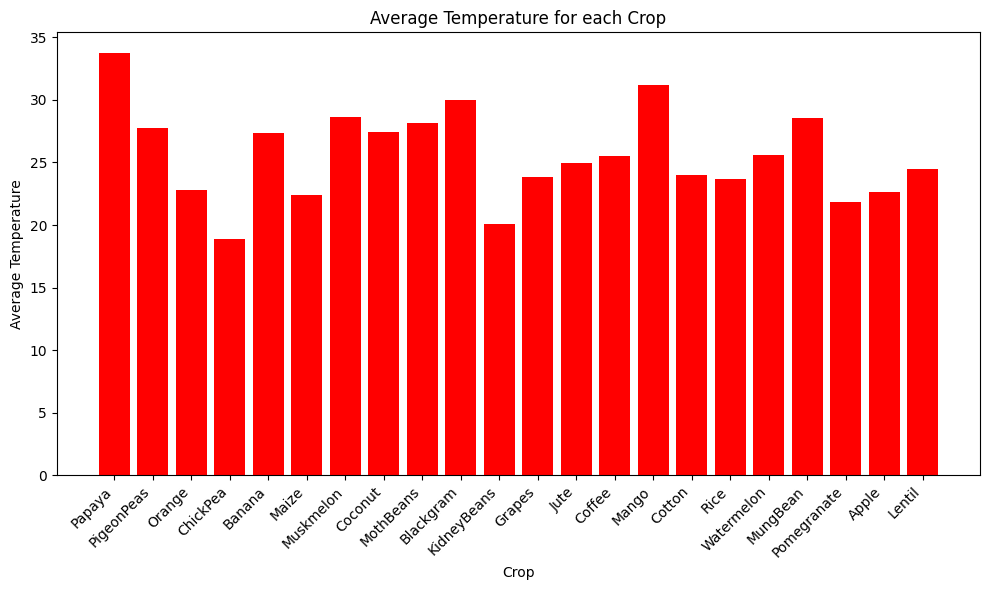

In [14]:
# Convert to Pandas DataFrame to use for the plotting
avg_temp_dff=avg_temp_df.toPandas()

#Plot the data
plt.figure(figsize=(10, 6))
plt.bar(avg_temp_dff['crop'], avg_temp_dff['avg_temperature'],color='red')
plt.xlabel('Crop')
plt.ylabel('Average Temperature')
plt.title('Average Temperature for each Crop')
# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

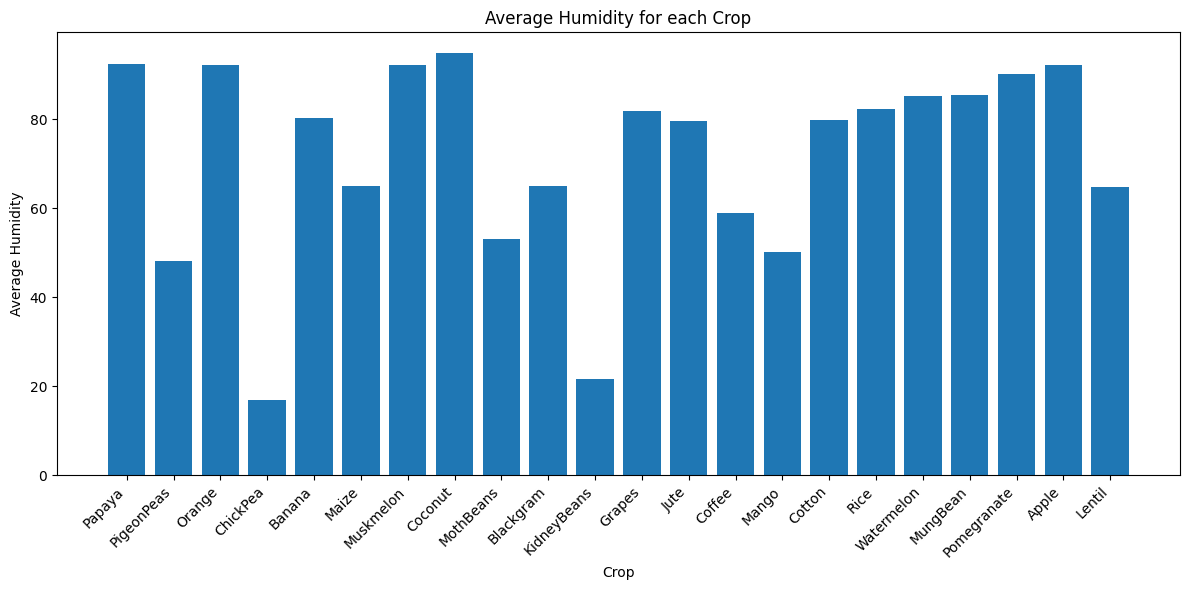

In [15]:
# Calculate average humidity for each crop
avg_humidity_df = df.groupBy("crop").agg(F.avg("humidity").alias("avg_humidity"))

# Convert to Pandas DataFrame to use for the plotting
avg_humidity_dff=avg_humidity_df.toPandas()

#Plot the data as a bar chart
plt.figure(figsize=(12, 6))
plt.bar(avg_humidity_dff['crop'], avg_humidity_dff['avg_humidity'])
plt.xlabel('Crop')
plt.ylabel('Average Humidity')
plt.title('Average Humidity for each Crop')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()  # Adjust layout to make room for rotated labels
plt.show()

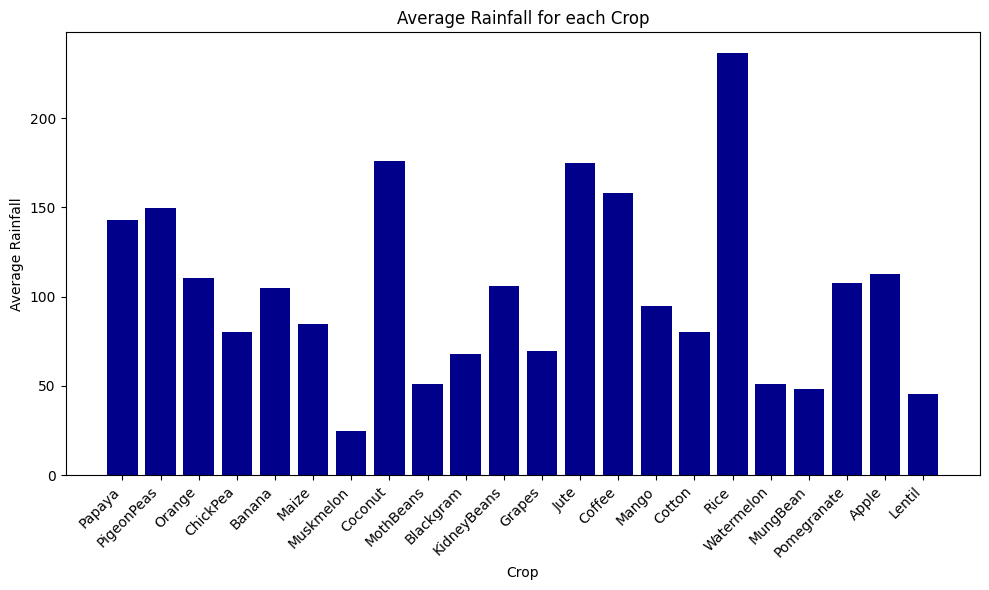

In [16]:
# Calculate average Rainfull for each crop
avg_rainfall_df = df.groupBy("crop").agg(F.avg("Rainfall").alias("avg_Rainfall"))

# Convert to Pandas DataFrame to use for the plotting
avg_rainfall_dff=avg_rainfall_df.toPandas()

#Plot the data
plt.figure(figsize=(10, 6))
plt.bar(avg_rainfall_dff['crop'], avg_rainfall_dff['avg_Rainfall'],color='#00008B')
plt.xlabel('Crop')
plt.ylabel('Average Rainfall')
plt.title('Average Rainfall for each Crop')
# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



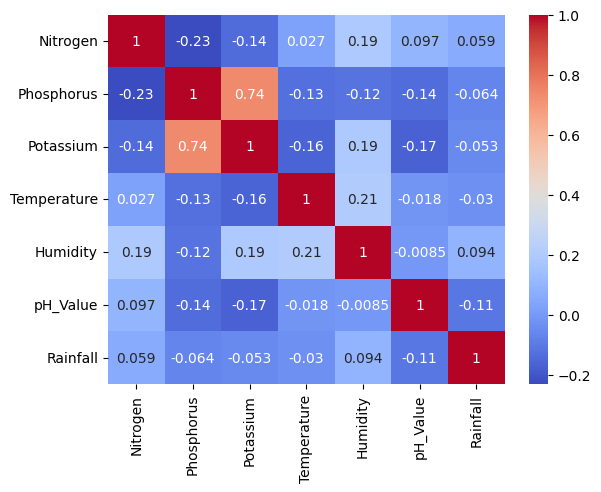

In [17]:
#heatmap and drop crop column (categorical variable)
sns.heatmap(df.drop('Crop').toPandas().corr(), annot=True, cmap='coolwarm')
plt.show()

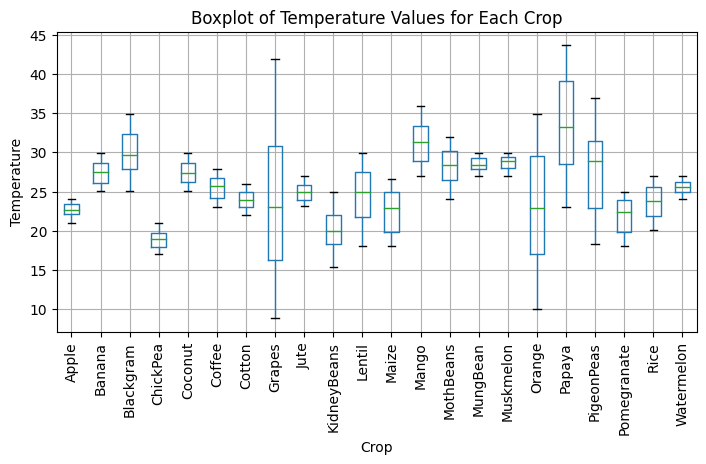

In [18]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

temperature_data = df.select("Crop", "Temperature").toPandas()
fig, ax = plt.subplots(figsize=(8, 4))
temperature_data.boxplot(column='Temperature', by='Crop', ax=ax)

plt.xticks(rotation=90)
plt.xlabel('Crop')
plt.ylabel('Temperature')
plt.title('Boxplot of Temperature Values for Each Crop')
plt.suptitle('')

plt.show()

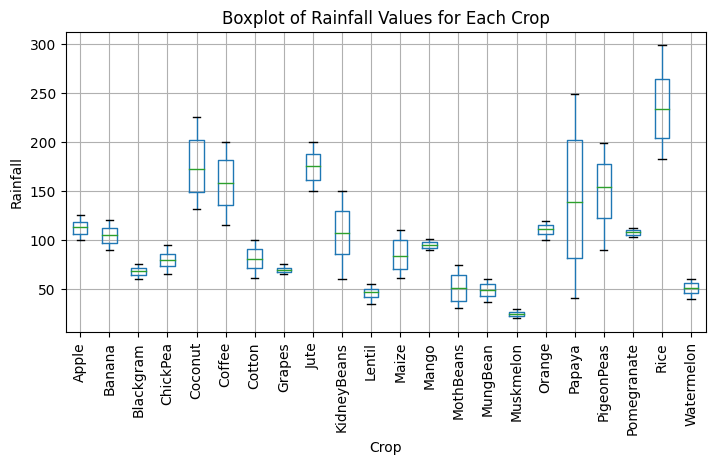

In [19]:
temperature_data = df.select("Crop", "Rainfall").toPandas()
fig, ax = plt.subplots(figsize=(8, 4))
temperature_data.boxplot(column='Rainfall', by='Crop', ax=ax)

plt.xticks(rotation=90)
plt.xlabel('Crop')
plt.ylabel('Rainfall')
plt.title('Boxplot of Rainfall Values for Each Crop')
plt.suptitle('')

plt.show()

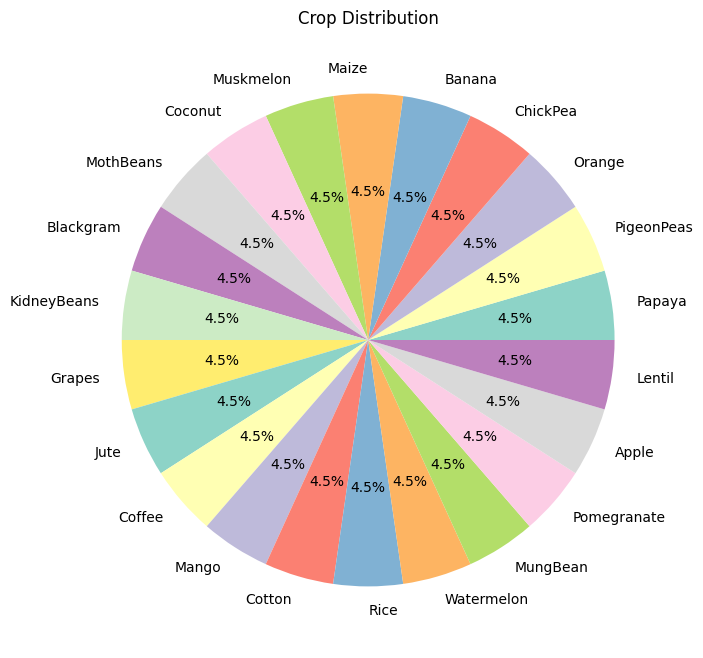

In [20]:
import matplotlib.cm as cm
import numpy as np

#crop count plot
crop_count = df.groupBy("Crop").count()

# Convert to Pandas DataFrame to use for the plotting
crop_count_pd = crop_count.toPandas()
colors = sns.color_palette("Set3", 22)
# Plot the pie chart
plt.figure(figsize=(10, 8))
plt.pie(crop_count_pd['count'], labels=crop_count_pd['Crop'], autopct='%1.1f%%',colors=colors)
plt.title('Crop Distribution')
plt.show()


In [21]:
crop_count.show()

+-----------+-----+
|       Crop|count|
+-----------+-----+
|     Papaya|  100|
| PigeonPeas|  100|
|     Orange|  100|
|   ChickPea|  100|
|     Banana|  100|
|      Maize|  100|
|  Muskmelon|  100|
|    Coconut|  100|
|  MothBeans|  100|
|  Blackgram|  100|
|KidneyBeans|  100|
|     Grapes|  100|
|       Jute|  100|
|     Coffee|  100|
|      Mango|  100|
|     Cotton|  100|
|       Rice|  100|
| Watermelon|  100|
|   MungBean|  100|
|Pomegranate|  100|
+-----------+-----+
only showing top 20 rows



This indicates that the crop variable has exactly balanced values, we have 22 labels each counts 100 instance

#5.Data preprocessing

## 5.1. Feature selection

In [22]:
from sklearn.ensemble import RandomForestClassifier

pandas_df=df.toPandas()
X = pandas_df.drop('Crop', axis=1)
y = pandas_df['Crop']

# Train a Random Forest classifier
clf = RandomForestClassifier()
clf.fit(X, y)

# Extract feature importances
feature_importances = clf.feature_importances_

# Print feature importances
for i, feature in enumerate(X.columns):
    print(f'Feature: {feature}, Importance: {feature_importances[i]}')

Feature: Nitrogen, Importance: 0.10594125924980588
Feature: Phosphorus, Importance: 0.14483012736309045
Feature: Potassium, Importance: 0.1796242668649102
Feature: Temperature, Importance: 0.07697243999542135
Feature: Humidity, Importance: 0.21536907775854255
Feature: pH_Value, Importance: 0.053917752200332784
Feature: Rainfall, Importance: 0.22334507656789682


In [23]:
print(numerical_features)

DataFrame[Nitrogen: float, Phosphorus: float, Potassium: float, Temperature: float, Humidity: float, pH_Value: float, Rainfall: float]


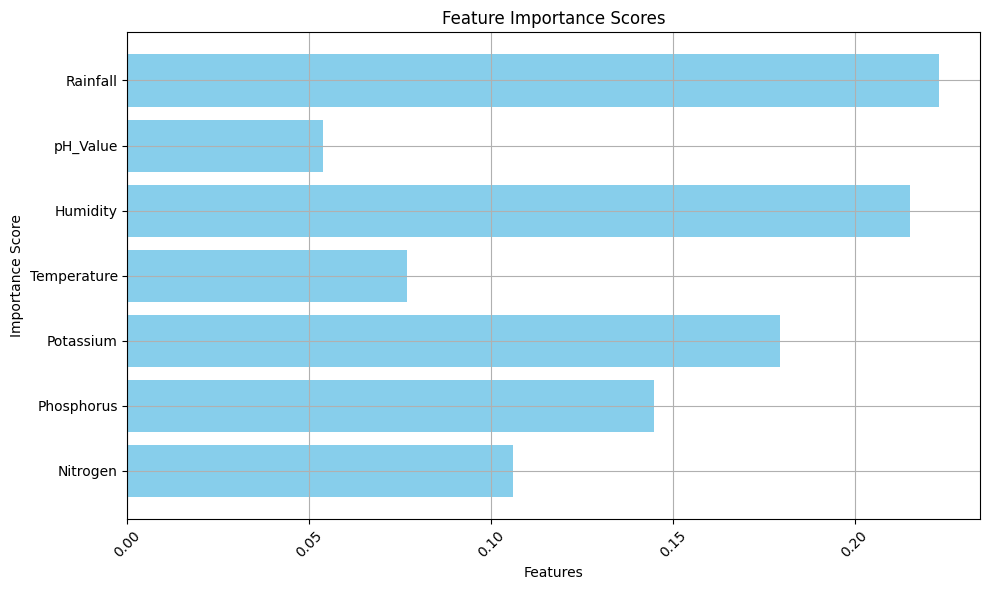

In [24]:
# Visualize feature importances
plt.figure(figsize=(10, 6))
plt.barh(X.columns, feature_importances, color='skyblue')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.title('Feature Importance Scores')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [25]:
#drop phosphorus to remove colinearity in the model since it's less important than Potassium
df=df.drop('Phosphorus')
df.show(n=5)

+--------+---------+-----------+--------+---------+---------+----+
|Nitrogen|Potassium|Temperature|Humidity| pH_Value| Rainfall|Crop|
+--------+---------+-----------+--------+---------+---------+----+
|    90.0|     43.0|  20.879744|82.00275|6.5029855|202.93553|Rice|
|    85.0|     41.0|  21.770462|80.31964|7.0380964|226.65553|Rice|
|    60.0|     44.0|   23.00446|82.32076| 7.840207|263.96423|Rice|
|    74.0|     40.0|  26.491096|80.15836| 6.980401|242.86403|Rice|
|    78.0|     42.0|  20.130175|81.60487| 7.628473|262.71735|Rice|
+--------+---------+-----------+--------+---------+---------+----+
only showing top 5 rows



##5.2. encoding of target variable

In [26]:
# Encoding the crop feature (Target variable)
from pyspark.ml.feature import StringIndexer

# Initialize StringIndexer
indexer = StringIndexer(inputCol="Crop", outputCol="Crop_encoded")

# Fit and transform the DataFrame
df = indexer.fit(df).transform(df)

# Show the DataFrame with the new indexed column
df.show(n=10)
df.printSchema()


+--------+---------+-----------+---------+---------+---------+----+------------+
|Nitrogen|Potassium|Temperature| Humidity| pH_Value| Rainfall|Crop|Crop_encoded|
+--------+---------+-----------+---------+---------+---------+----+------------+
|    90.0|     43.0|  20.879744| 82.00275|6.5029855|202.93553|Rice|        20.0|
|    85.0|     41.0|  21.770462| 80.31964|7.0380964|226.65553|Rice|        20.0|
|    60.0|     44.0|   23.00446| 82.32076| 7.840207|263.96423|Rice|        20.0|
|    74.0|     40.0|  26.491096| 80.15836| 6.980401|242.86403|Rice|        20.0|
|    78.0|     42.0|  20.130175| 81.60487| 7.628473|262.71735|Rice|        20.0|
|    69.0|     42.0|  23.058048| 83.37012|7.0734534|  251.055|Rice|        20.0|
|    69.0|     38.0|  22.708838| 82.63941|5.7008057|271.32486|Rice|        20.0|
|    94.0|     40.0|  20.277744| 82.89409| 5.718627| 241.9742|Rice|        20.0|
|    89.0|     38.0|   24.51588| 83.53522|6.6853466|230.44624|Rice|        20.0|
|    68.0|     38.0|  23.223

# 6.Models

In [27]:
from sklearn.tree import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import time
import sys

##6.1. Vector Assembler

In [28]:
# Assemble the feature columns into a single vector column
assembler = VectorAssembler(inputCols=['Nitrogen', 'Potassium', 'Temperature', 'Humidity', 'pH_Value', 'Rainfall'], outputCol="features")
assembled_df= assembler.transform(df)
assembled_df.show(n=5)

+--------+---------+-----------+--------+---------+---------+----+------------+--------------------+
|Nitrogen|Potassium|Temperature|Humidity| pH_Value| Rainfall|Crop|Crop_encoded|            features|
+--------+---------+-----------+--------+---------+---------+----+------------+--------------------+
|    90.0|     43.0|  20.879744|82.00275|6.5029855|202.93553|Rice|        20.0|[90.0,43.0,20.879...|
|    85.0|     41.0|  21.770462|80.31964|7.0380964|226.65553|Rice|        20.0|[85.0,41.0,21.770...|
|    60.0|     44.0|   23.00446|82.32076| 7.840207|263.96423|Rice|        20.0|[60.0,44.0,23.004...|
|    74.0|     40.0|  26.491096|80.15836| 6.980401|242.86403|Rice|        20.0|[74.0,40.0,26.491...|
|    78.0|     42.0|  20.130175|81.60487| 7.628473|262.71735|Rice|        20.0|[78.0,42.0,20.130...|
+--------+---------+-----------+--------+---------+---------+----+------------+--------------------+
only showing top 5 rows



##6.2. Splitting the data in training and testing sets

In [29]:
# Split data into training and testing sets
train_data, test_data = assembled_df.randomSplit([0.8, 0.2], seed=42)

## 6.3 Decision Tree

In [30]:
import time
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

accuracy_evaluator = MulticlassClassificationEvaluator(labelCol='Crop_encoded', predictionCol='prediction', metricName='accuracy')
precision_evaluator = MulticlassClassificationEvaluator(labelCol='Crop_encoded', predictionCol='prediction', metricName='weightedPrecision')
recall_evaluator = MulticlassClassificationEvaluator(labelCol='Crop_encoded', predictionCol='prediction', metricName='weightedRecall')
f1_evaluator = MulticlassClassificationEvaluator(labelCol='Crop_encoded', predictionCol='prediction', metricName='f1')

# Initialize lists to store metrics
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
training_times = []

# Loop 30 times
for _ in range(30):
    # Create a DecisionTreeClassifier instance
    dt = DecisionTreeClassifier(maxDepth=5).setFeaturesCol('features').setLabelCol('Crop_encoded')

    # Measure training time
    start_time = time.time()
    # Train the model on the training data
    model = dt.fit(train_data)
    end_time = time.time()

    training_time = end_time - start_time
    training_times.append(training_time)

    # Make predictions on the test data
    predictions = model.transform(test_data)

    # Evaluate metrics and convert to float
    accuracy = accuracy_evaluator.evaluate(predictions)
    precision = precision_evaluator.evaluate(predictions)
    recall = recall_evaluator.evaluate(predictions)
    f1 = f1_evaluator.evaluate(predictions)

    # Append metrics to respective lists
    accuracy_list.append(float(accuracy))
    precision_list.append(float(precision))
    recall_list.append(float(recall))
    f1_list.append(float(f1))

DT_accurcacy_mean= np.mean(accuracy_list)
print(f" DT Mean Accuracy: {DT_accurcacy_mean:.4f}")

DT_precision_mean= np.mean(precision_list)
print(f" DT Mean Precision: {DT_precision_mean:.4f}")

DT_recall_mean= np.mean(recall_list)
print(f" DT Mean Recall: {DT_recall_mean:.4f}")

DT_f1_mean= np.mean(f1_list)
print(f" DT Mean F1 Score: {DT_f1_mean:.4f}")

DT_training_times= np.sum(training_times)
print(f" DT Training Time: {DT_training_times:.4f}")

 DT Mean Accuracy: 0.5590
 DT Mean Precision: 0.5018
 DT Mean Recall: 0.5590
 DT Mean F1 Score: 0.4740
 DT Training Time: 38.4632


##6.4. Random Forest

In [31]:
# Initialize list to store metrics
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
training_times = []

# Loop 30 times
for _ in range(30):
    # Create a RandomForestClassifier instance
    rf = RandomForestClassifier(numTrees=50).setFeaturesCol('features').setLabelCol('Crop_encoded')

    # Measure training time
    start_time = time.time()
    # Train the model on the training data
    model = rf.fit(train_data)
    end_time = time.time()

    training_time = end_time - start_time
    training_times.append(training_time)

    # Make predictions on the test data
    predictions = model.transform(test_data)

    # Evaluate metrics and convert to float
    accuracy = accuracy_evaluator.evaluate(predictions)
    precision = precision_evaluator.evaluate(predictions)
    recall = recall_evaluator.evaluate(predictions)
    f1 = f1_evaluator.evaluate(predictions)

    # Append metrics to respective lists
    accuracy_list.append(float(accuracy))
    precision_list.append(float(precision))
    recall_list.append(float(recall))
    f1_list.append(float(f1))

RF_accurcacy_mean= np.mean(accuracy_list)
print(f" RF Mean Accuracy: {RF_accurcacy_mean:.4f}")

RF_precision_mean= np.mean(precision_list)
print(f" RF Mean Precision: {RF_precision_mean:.4f}")

RF_recall_mean= np.mean(recall_list)
print(f" RF Mean Recall: {RF_recall_mean:.4f}")

RF_f1_mean= np.mean(f1_list)
print(f" RF Mean F1 Score: {RF_f1_mean:.4f}")

RF_training_times= np.sum(training_times)
print(f" RF Training Time: {RF_training_times:.4f}")

 RF Mean Accuracy: 0.9590
 RF Mean Precision: 0.9651
 RF Mean Recall: 0.9590
 RF Mean F1 Score: 0.9565
 RF Training Time: 47.3671


# 7.Performance Evaluation

In [32]:
dt_metrics = {
    'Model': 'Decision Tree',
    'Accuracy': DT_accurcacy_mean,
    'Precision': DT_precision_mean,
    'Recall': DT_recall_mean,
    'F1 Score': DT_f1_mean,
    'Training Time': DT_training_times
}

rf_metrics = {
    'Model': 'Random Forest',
    'Accuracy': RF_accurcacy_mean,
    'Precision': RF_precision_mean,
    'Recall': RF_recall_mean,
    'F1 Score': RF_f1_mean,
    'Training Time': RF_training_times
}

# Combine metrics into a list
metrics_data = [dt_metrics, rf_metrics]

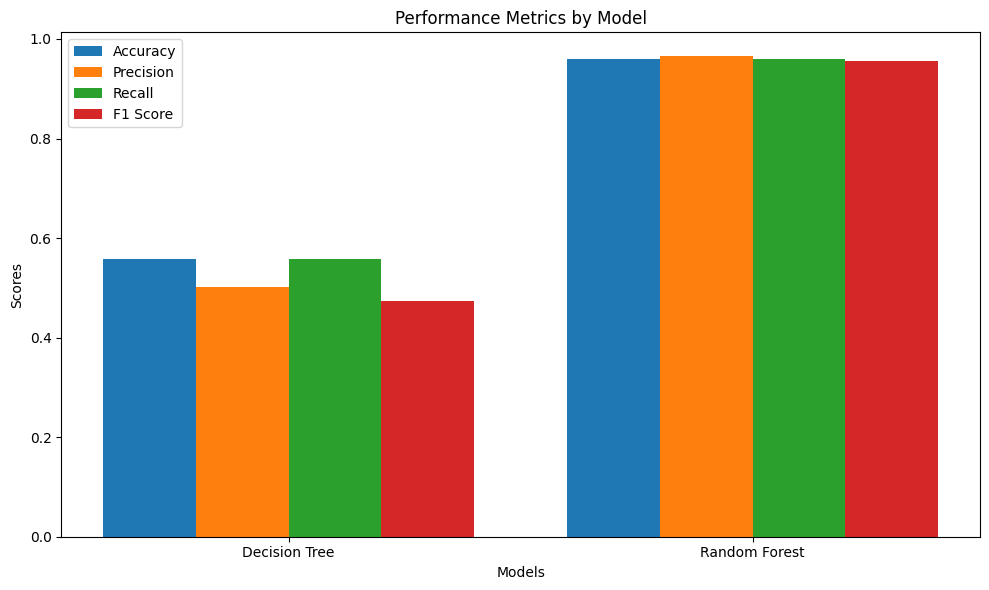

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Extract metrics for plotting
models = [entry['Model'] for entry in metrics_data]
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [[entry[metric] for metric in metrics] for entry in metrics_data]

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.2
index = np.arange(len(models))

for i, metric in enumerate(metrics):
    ax.bar(index + i * bar_width, [value[i] for value in values], bar_width, label=metric)

ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Performance Metrics by Model')
ax.set_xticks(index + 0.3)
ax.set_xticklabels(models)
ax.legend()

plt.tight_layout()
plt.show()

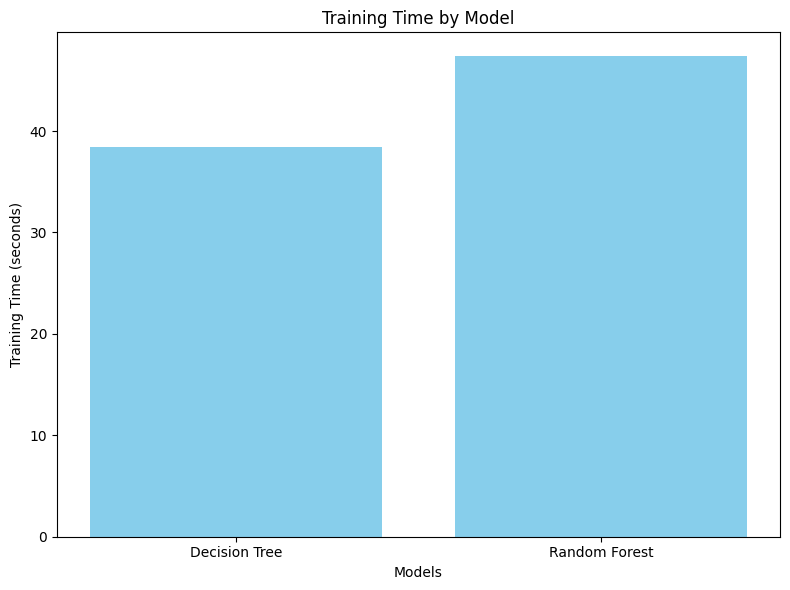

In [34]:
# Extract training times for plotting
training_times = [entry['Training Time'] for entry in metrics_data]

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))

ax.bar(models, training_times, color='skyblue')
ax.set_xlabel('Models')
ax.set_ylabel('Training Time (seconds)')
ax.set_title('Training Time by Model')

plt.tight_layout()
plt.show()

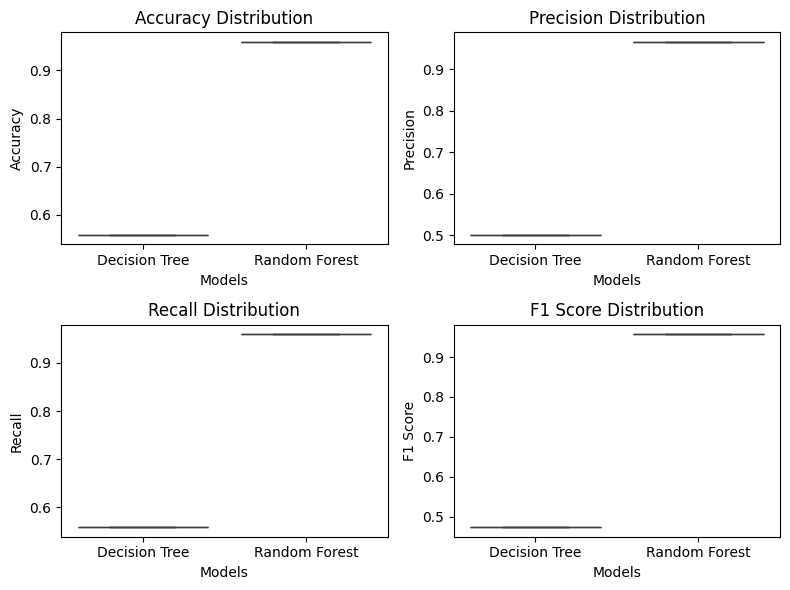

In [35]:
import seaborn as sns
import pandas as pd

# Create a DataFrame for box plots
df = pd.DataFrame(metrics_data)

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    sns.boxplot(x='Model', y=metric, data=df, ax=axes[i])
    axes[i].set_title(f'{metric} Distribution')
    axes[i].set_xlabel('Models')
    axes[i].set_ylabel(metric)

plt.tight_layout()
plt.show()